In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
from nlinec import get_positive_data, get_all_types, get_results_dir, get_type, color_palette, get_models_dir
from nlinec.data.preprocessing import get_granularity

## Parameters

In [3]:
granularities = ['Coarse', 'Medium', 'Fine']

In [4]:
models = os.listdir(get_models_dir())
print(models)

['nlinec-E-2', 'nlinec-C-2', 'nlinec-D-1', 'nlinec-D-2', 'nlinec-D-3']


In [5]:
# Specify the dataset to predict and a file to load the predictions from
SPLIT = "test"
DATASET = f'g_{SPLIT}.json'
MODEL = "nlinec-D-2"
# MODEL = "roberta-large-mnli"
HYPOTHESIS_ONLY = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODEL_TO = os.path.join(get_models_dir(), MODEL)
SAVE_PREDICTIONS_TO = os.path.join(get_results_dir(), MODEL, f"{SPLIT}_predictions" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv")

## Setup 

In [6]:
positive_data = get_positive_data(DATASET)
positive_data

Loading g_test.json: 8963it [00:00, 50252.57it/s]


,mention_span,full_type,sentence,label
0,Valley Federal Savings & Loan Association,"[/organization, /organization/company]",Valley Federal Savings & Loan Association sai...,2
1,Valley Federal,"[/organization, /organization/company]","Terms weren't disclosed, but Valley Federal ha...",2
2,Valley Federal,"[/organization, /organization/company]",Valley Federal said Friday that it is conside...,2
3,"Valley Federal , with assets of $ 3.3 billion ,","[/organization, /organization/company]","Valley Federal , with assets of $ 3.3 billion...",2
4,Imperial Corp. of America,"[/organization, /organization/company]",Valley Federal Savings & Loan Association said...,2
...,...,...,...,...
8958,"Fridays in general , which tend to be strong d...",[/other],Another study found that the 82 Fridays the 13...,2
8959,stocks,[/other],"But the date tends to be a plus, not a minus, ...",2
8960,the 1962 - 85 period,[/other],"But their study, which spanned the 1962 - 85 p...",2
8961,professors,[/person],"Robert Kolb and Ricardo Rodriguez, professors ...",2


In [7]:
gran_types = []
for i in [1, 2, 3]:
    all_types = get_all_types(granularity=i)
    all_types['granularity'] = all_types['full_type'].apply(lambda x: get_granularity(x))
    gran_types.append(all_types[all_types['granularity'] == i])

## Evaluate

In [8]:
# Get the predictions
predictions_df = pd.read_csv(SAVE_PREDICTIONS_TO, index_col=0)

# Combine the predictions with the original data based on the index
data_with_predictions = positive_data.join(predictions_df).explode('full_type')

# Add the granularity of the type
data_with_predictions['granularity'] = data_with_predictions['full_type'].apply(get_granularity)

# Reset the index
data_with_predictions.reset_index(drop=True, inplace=True)

In [9]:
# Compute the predicted type for each granularity
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the predicted type (i.e. the the name of the column with the maximum probability)
    data_with_predictions.loc[granularity_mask, 'predicted_type'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].idxmax(axis=1)

### Accuracy

In [10]:
# Compute the overall accuracy for each granularity
accuracy = pd.DataFrame(columns=['granularity', 'accuracy'], index=[0, 1, 2])
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy
    # accuracy.append((data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean())
    accuracy.loc[i - 1, 'granularity'] = i
    accuracy.loc[i - 1, 'accuracy'] = (data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean()

    # Add a column that stores if the prediction was correct
    data_with_predictions.loc[granularity_mask, 'correct'] = data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']

accuracy

,granularity,accuracy
0,1,0.611846
1,2,0.701221
2,3,0.707434


In [11]:
# Save the accuracy to a csv file
accuracy.to_csv(os.path.join(get_results_dir(), MODEL, f"{SPLIT}_accuracy" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv"))

### Accuracy per type

In [12]:
# Compute the accuracy for each type at each granularity
type_accuracy_list = []
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy for each type
    type_accuracy = data_with_predictions.loc[granularity_mask, ['full_type', 'correct']].groupby('full_type').mean().reset_index()
    type_accuracy['granularity'] = i
    type_accuracy_list.append(type_accuracy)

type_accuracy = pd.concat(type_accuracy_list)
type_accuracy.rename(columns={'correct': 'accuracy'}, inplace=True)
type_accuracy.sort_values(by=['full_type'], inplace=True)
type_accuracy.reset_index(drop=True, inplace=True)

In [13]:
# Save the type accuracy to a csv file
type_accuracy.to_csv(os.path.join(get_results_dir(), MODEL, f"{SPLIT}_type_accuracy" + ("_ho" if HYPOTHESIS_ONLY else "") + ".csv"))

In [20]:
type_accuracy.sort_values(by=['accuracy', 'granularity'], ascending=[True, True])

,full_type,accuracy,granularity
23,/organization/military,0.0,2
27,/organization/transit,0.0,2
46,/other/legal,0.0,2
55,/other/sports_and_leisure,0.0,2
56,/other/supernatural,0.0,2
...,...,...,...
39,/other/event/protest,1.0,3
40,/other/event/sports_event,1.0,3
51,/other/product/computer,1.0,3
53,/other/product/weapon,1.0,3


In [26]:
data_with_predictions_ignored_types = data_with_predictions[data_with_predictions['full_type'].isin(type_accuracy[type_accuracy['accuracy'] == 0]['full_type'])]

In [29]:
data_with_predictions_ignored_types[(data_with_predictions_ignored_types['full_type'] == '/other/legal') & (data_with_predictions_ignored_types['predicted_type'] == '/other/event')]

,mention_span,full_type,sentence,label,/other,/location/country,/location,/other/scientific,/location/city,/other/product,...,/organization/transit,/location/structure/theater,/location/geography/body_of_water,/location/geograpy/island,/location/geograpy,/other/legal,/other/product/mobile_phone,granularity,predicted_type,correct
680,a criminal investigation,/other/legal,Food and Drug Administration spokesman Jeff Ne...,2,0.849365,0.001061,0.072937,0.027604,0.031738,0.009611,...,0.001652,0.001924,0.003010,0.004261,0.000734,0.775487,0.002836,2,/other/event,False
1328,Middle East and Third World weapons contracts,/other/legal,The sudden romance of British Aerospace and Th...,2,0.253709,0.022013,0.835362,0.011707,0.004523,0.068313,...,0.002161,0.002178,0.003703,0.003427,0.001160,0.004274,0.003779,2,/other/event,False
3265,extradition proceedings,/other/legal,A spokesman for the U.S. Attorney's office sai...,2,0.536126,0.022278,0.121479,0.037762,0.017528,0.004264,...,0.015940,0.003278,0.008356,0.017695,0.000640,0.411627,0.005475,2,/other/event,False
3756,a subsequent criminal prosecution,/other/legal,Allowing the defendant to take the Fifth in a ...,2,0.259401,0.001531,0.005774,0.003746,0.005750,0.004122,...,0.002911,0.003786,0.001266,0.001144,0.001865,0.114036,0.002201,2,/other/event,False
3773,a criminal case,/other/legal,"Thus, in a criminal case , a prosecutor can no...",2,0.464273,0.000990,0.006531,0.003211,0.002671,0.002134,...,0.001346,0.001859,0.000873,0.001009,0.000755,0.854257,0.001175,2,/other/event,False
3977,any criminal case,/other/legal,The Fifth Amendment states in relevant part th...,2,0.559355,0.001031,0.011561,0.003077,0.003634,0.003293,...,0.002781,0.001668,0.001959,0.002030,0.000938,0.734669,0.002202,2,/other/event,False
3984,a crime,/other/legal,"The subcommittee, Congress and the American pu...",2,0.813351,0.002507,0.027098,0.002411,0.005383,0.008881,...,0.002251,0.002320,0.003209,0.004511,0.001295,0.163507,0.004597,2,/other/event,False
3995,a noncriminal proceeding,/other/legal,"Thus, when Mr. Pierce asserted the Fifth in a ...",2,0.579793,0.001978,0.013664,0.005775,0.008427,0.004145,...,0.003019,0.003324,0.002210,0.002507,0.002090,0.842864,0.002506,2,/other/event,False
4057,a subsequent criminal prosecution,/other/legal,"Thus, when Mr. Pierce asserted the Fifth in a ...",2,0.609492,0.001230,0.010793,0.003122,0.005665,0.004860,...,0.002210,0.002457,0.000906,0.001260,0.001321,0.305230,0.001753,2,/other/event,False
4394,GATT,/other/legal,Uruguay resolutely supports the recovery of Ch...,2,0.095497,0.512096,0.082407,0.022137,0.004026,0.017491,...,0.003142,0.002017,0.003273,0.003887,0.001150,0.007557,0.001893,2,/other/event,False


In [27]:
pd.crosstab(data_with_predictions_ignored_types['full_type'], data_with_predictions_ignored_types['predicted_type'])

predicted_type,/location/city,/location/country,/location/structure,/location/transit,/organization/company,/organization/company/news,/organization/government,/organization/sports_team,/other/art,/other/art/broadcast,...,/other/event,/other/event/sports_event,/other/food,/other/health,/other/living_thing,/other/product,/person/artist,/person/legal,/person/military,/person/title
full_type,,,,,,,,,,,,,,,,,,,,,
/organization/company/broadcast,0,0,0,0,0,1,0,0,0,16,...,0,0,0,0,0,0,0,0,0,0
/organization/military,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,1
/organization/transit,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/other/art/music,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/other/art/stage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/other/event/holiday,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
/other/legal,3,14,5,0,24,0,21,1,20,0,...,22,0,1,5,0,18,4,60,8,59
/other/sports_and_leisure,0,0,0,0,0,0,0,1,0,0,...,2,0,0,2,0,0,1,0,0,0
/other/supernatural,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Probability Bands

In [15]:
# Now compute the accuracy in prediction bands of 10% (i.e. 0-10%, 10-20%, etc.)
# First, compute the probability of the correct type
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the probability of the correct type
    data_with_predictions.loc[granularity_mask, 'predicted_type_probability'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].max(axis=1)

In [16]:
# Compute the accuracy in each band
probability_bands = np.linspace(0, 1, 11)
band_accuracy_at_granularity = [pd.DataFrame(columns=['band', 'accuracy', 'support'], index=range(len(probability_bands) - 1)) for _ in range(3)]
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy in each band
    for j in range(len(probability_bands) - 1):
        # Get the rows where the probability of the correct type is in the current band
        band_mask = (data_with_predictions['predicted_type_probability'] >= probability_bands[j]) & (data_with_predictions['predicted_type_probability'] < probability_bands[j + 1])

        # Compute the accuracy
        band_accuracy_at_granularity[i - 1].loc[j, 'band'] = f"{probability_bands[j + 1]*100:.0f}"
        band_accuracy_at_granularity[i - 1].loc[j, 'accuracy'] = (data_with_predictions.loc[granularity_mask & band_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask & band_mask, 'full_type']).mean()
        band_accuracy_at_granularity[i - 1].loc[j, 'support'] = (data_with_predictions.loc[granularity_mask & band_mask].shape[0])

/tmp/ipykernel_3804/3663011026.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(band_accuracy_at_granularity[i]['band'])


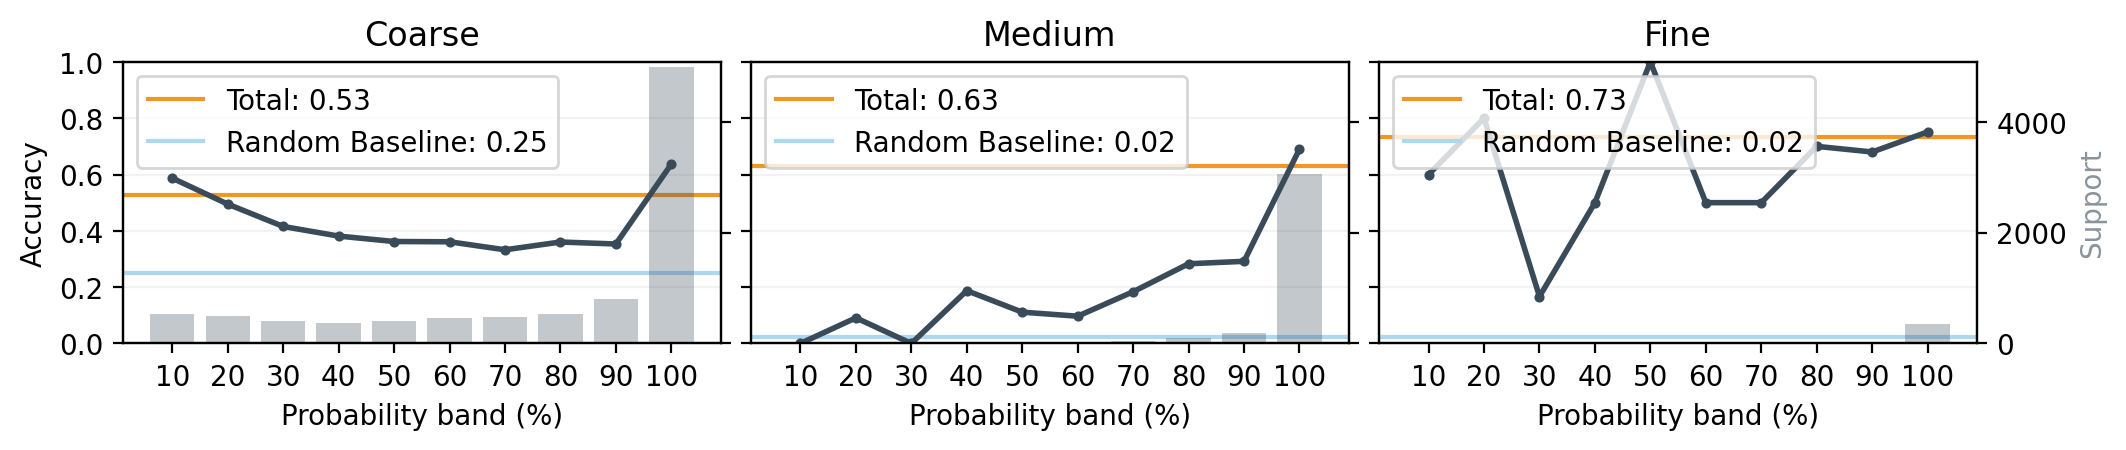

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2), dpi=200)
fig.tight_layout(w_pad=-2)
for i, ax in enumerate(axes):
    ax.plot(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), linewidth=2, zorder=3)
    ax.scatter(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), s=7, zorder=3)
    ax.set_title(granularities[i])
    ax.set_xlabel("Probability band (%)")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(band_accuracy_at_granularity[i]['band'])

    ax.axhline(accuracy.loc[i, 'accuracy'], color=color_palette('accent'), label=f'Total: {accuracy.loc[i, "accuracy"]:.2f}', zorder=2)
    ax.axhline(1 / gran_types[i].shape[0], color=color_palette('light'), label=f'Random Baseline: {1 / gran_types[i].shape[0]:.2f}', zorder=2)

    # Draw a bar for the support
    ax2 = ax.twinx()
    ax2.bar(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['support'], color=color_palette('medium'), alpha=0.3)
    ax2.set_ylim(0, 1.02 * max([band_accuracy_at_granularity[i]['support'].max() for i in range(3)]))

    if i != 2:
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel("Support", color=color_palette('medium'), alpha=0.6)

    ax.grid(axis='y', color=color_palette('bright'), zorder=0)

    # Show the legend on top of the other elements
    ax.legend(loc='upper left')

axes[0].set_ylabel("Accuracy")
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.savefig(os.path.join(get_results_dir(), f'{MODEL}', f"{SPLIT}_accuracy_by_probability_band" + ("_ho" if HYPOTHESIS_ONLY else "") + '.png'), bbox_inches='tight')

### Sibling & Hypernym Probability

In [18]:
# Get the full_type and predicted type at each granularity
for i in [1, 2, 3]:
    # Get the ground truth type at the current granularity
    data_with_predictions[f'type_{i}'] = data_with_predictions['full_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}'] = data_with_predictions['predicted_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the probability of the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}_probability'] = data_with_predictions.apply(lambda row: row.get(get_type(row['predicted_type'], include_path=True, granularity=i)), axis=1)

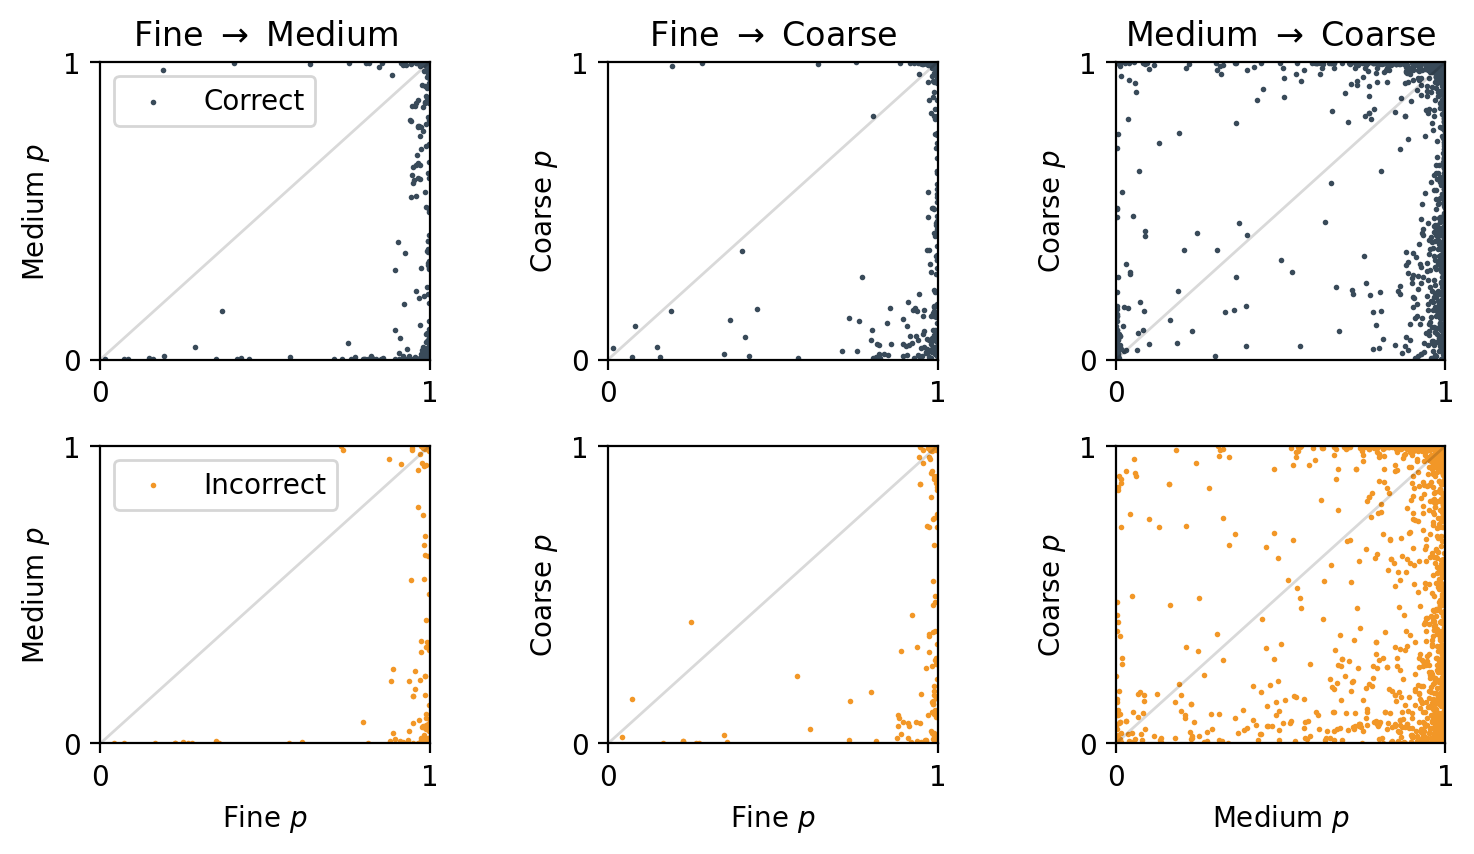

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(7.5, 4), dpi=200)
fig.tight_layout(w_pad=3, h_pad=1)
for i, (ax_row, color, mask, label) in enumerate(zip(axes, [color_palette('medium'), color_palette('accent')], [data_with_predictions['correct'].values, ~(data_with_predictions['correct'].astype(bool))], ['Correct', 'Incorrect'])):
    for j, (ax, (granularity_name, hypernym_granularity_name), (granularity, hypernym_granularity)) in enumerate(zip(ax_row, [('Fine', 'Medium'), ('Fine', 'Coarse'), ('Medium', 'Coarse')], [(3, 2), (3, 1), (2, 1)])):
        ax.scatter(data_with_predictions.loc[mask, f'predicted_type_{granularity}_probability'], data_with_predictions.loc[mask, f'predicted_type_{hypernym_granularity}_probability'], s=1, color=color, label=label)
        ax.plot([0, 1], [0, 1], color='k', linewidth=1, alpha=0.15)
        if i == 0:
            ax.set_title(f'{granularity_name} $\\rightarrow$ {hypernym_granularity_name}')
        if i == 1:
            ax.set_xlabel(f'{granularity_name} $p$')
        ax.set_ylabel(f'{hypernym_granularity_name} $p$')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        if j == 0:
            ax.legend(loc='upper left')

fig.savefig(os.path.join(get_results_dir(), f'{MODEL}', f"{SPLIT}_hypernym_probability" + ("_ho" if HYPOTHESIS_ONLY else "") + '.png'), bbox_inches='tight')

In [23]:
def show_probabilities(index):
    granularity_colors = ['tab:blue', 'tab:orange', 'tab:green']
    granularity_labels = ['Coarse-grained', 'Medium-grained', 'Fine-grained']

    sentence = data_with_predictions.loc[index, 'sentence']
    mention_span = data_with_predictions.loc[index, 'mention_span']
    probabilities = data_with_predictions.loc[index, list(all_types['full_type'])].sort_index()
    # Sort the columns alphabetically
    probabilities

    # Split the plot over multiple columns
    N_COLS = 3
    type_per_col = len(probabilities)// N_COLS

    fig, axes = plt.subplots(1, N_COLS, figsize=(5 * N_COLS, 20 // N_COLS))
    fig.tight_layout(w_pad=18)
    fig.subplots_adjust(top=0.9)
    # Mark the mention in the sentence in red
    sentence = sentence.replace(mention_span, f'[[{mention_span}]]')
    fig.suptitle(sentence.replace('$', '\$'))

    for a, ax in enumerate(axes):
        start = a * type_per_col
        end = (a + 1) * type_per_col
        for i, (type_, probability) in enumerate(probabilities.iloc[start:end].items()):
            ax.barh(len(probabilities.iloc[start:end]) - i, probability, color=granularity_colors[get_granularity(type_) - 1])
        ax.set_yticks(np.arange(1, len(probabilities.iloc[start:end]) + 1))
        ax.set_yticklabels(probabilities.index[start:end][::-1])
        ax.set_ylim(0, len(probabilities.iloc[start:end]) + 1)
        ax.set_xlim(0, 1)
        ax.set_xlabel('Frequency')

    # Add a legend
    granularity_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in granularity_colors]
    axes[-1].legend(granularity_handles, granularity_labels, loc='upper right');

    return fig, axes